**处理流程：** 不进行变换筛选特征
1. 缺失值填充 — 用 KNN（基于相似样本补齐）
2. 缩尾+Yeo-Johnson
3. 特征筛选 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# 公共常量定义
TARGET_COL = 'lipid(%)'

## 加载数据处理缺失值

In [2]:
df = pd.read_excel('../data/raw/row_data1.xlsx')
print(f'原始数据形状: {df.shape}')
print(f'缺失值统计:')
print(df.isnull().sum()[df.isnull().sum() > 0])

原始数据形状: (36, 19)
缺失值统计:
phosphate    8
dtype: int64


In [3]:
# 查看缺失值的具体情况
missing_cols = ['phosphate']

print('样本缺失：')
for col in missing_cols:
    missing_idx = df[df[col].isnull()].index.tolist()
    print(f'  {col}: {len(missing_idx)} 个缺失，第 {missing_idx} 行')

样本缺失：
  phosphate: 8 个缺失，第 [24, 25, 28, 29, 30, 31, 33, 35] 行


In [4]:
# 用 KNN 填充缺失值（只对数值列，避免用目标列参与填充）

print('KNN 填充缺失值：')
df_filled = df.copy()

# 仅对数值列做 KNN 填充，目标列不参与以避免泄露
numeric_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
imputer_cols = [c for c in numeric_cols if c != TARGET_COL]

missing_before = df_filled[imputer_cols].isna().sum()
imputer = KNNImputer(n_neighbors=5, weights='distance')

df_filled[imputer_cols] = imputer.fit_transform(df_filled[imputer_cols])

for col in missing_cols:
    before = missing_before.get(col, 0)
    after = df_filled[col].isna().sum()
    print(f'  {col}: 原有 {before} 个缺失，填充后剩余 {after} 个')


KNN 填充缺失值：
  phosphate: 原有 8 个缺失，填充后剩余 0 个


KNN 填充后数据形状: (36, 19)
数值列: 19 | 目标列: lipid(%)
正态性检验结果 (p<0.05 视为拒绝正态):
                           column   n        mean         std     shapiro_p   dagostino_p  shapiro_normal  \
0                              TP  36    0.479391    1.158045  1.160621e-10  4.871242e-15          reject   
1                       phosphate  36    0.158606    0.283614  1.016847e-08  7.574965e-09          reject   
2    Algal density（×10^5cells/ml)  36   19.846096   21.337451  1.782273e-07  5.929909e-06          reject   
3                ammonia nitrogen  36    0.402549    0.498770  3.535737e-06  1.795682e-04          reject   
4   Total photosynthetic pigments  36    0.662691    0.632212  5.203561e-06  1.861141e-05          reject   
5                       Turbidity  36   10.776111    9.533717  9.313034e-06  2.225784e-06          reject   
6                             BOD  36    4.444444    4.506785  1.679021e-05  2.218676e-03          reject   
7                        lipid(%)  36    5.073559    4.89

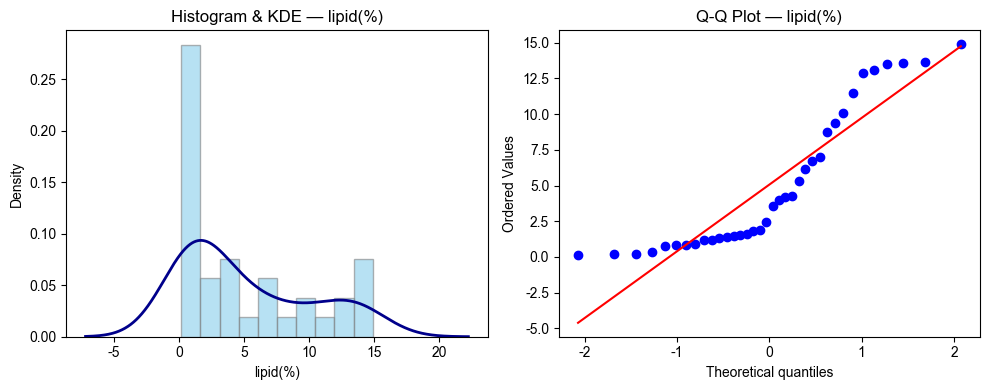

In [5]:
# KNN 填充后数据的正态性检验
from typing import Iterable

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

def infer_target_col(df, keywords: Iterable[str] = ('lipid', '脂质')) -> str:
    for col in df.columns:
        lower = str(col).lower()
        if any(key.lower() in lower for key in keywords):
            return col
    raise ValueError(f'No target column found containing any of {keywords}. Columns: {list(df.columns)}')

analysis_df = df_filled
y_col = infer_target_col(analysis_df)
num_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()

print(f'KNN 填充后数据形状: {analysis_df.shape}')
print(f'数值列: {len(num_cols)} | 目标列: {y_col}')

results = []
for col in num_cols:
    data = analysis_df[col].dropna().astype(float)
    n = len(data)
    if n < 8:  # normaltest 需要 n>=8
        continue
    shapiro_stat, shapiro_p = stats.shapiro(data)
    k2_stat, k2_p = stats.normaltest(data)
    results.append({
        'column': col,
        'n': n,
        'mean': data.mean(),
        'std': data.std(ddof=1),
        'shapiro_p': shapiro_p,
        'dagostino_p': k2_p,
        'shapiro_normal': 'fail to reject' if shapiro_p >= 0.05 else 'reject',
        'dagostino_normal': 'fail to reject' if k2_p >= 0.05 else 'reject',
    })

results_df = pd.DataFrame(results).sort_values('shapiro_p')
print('正态性检验结果 (p<0.05 视为拒绝正态):')
print(results_df.reset_index(drop=True))

# 直方图 + KDE 与 Q-Q 图，默认查看目标列，可根据需要改成其他列
column_to_plot = y_col
if column_to_plot not in num_cols:
    raise ValueError(f'Column {column_to_plot} not numeric. Choose one of: {num_cols}')

series = analysis_df[column_to_plot].dropna().astype(float)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(series, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='gray')
series.plot.kde(ax=axes[0], color='darkblue', lw=2)
axes[0].set_title(f'Histogram & KDE — {column_to_plot}')
axes[0].set_xlabel(column_to_plot)
axes[0].set_ylabel('Density')
stats.probplot(series, dist='norm', plot=axes[1])
axes[1].set_title(f'Q-Q Plot — {column_to_plot}')
plt.tight_layout()
plt.show()


In [6]:
output_path = '../data/processed/data_cleaned.xlsx'
df_filled.to_excel(output_path, index=False)
print(f'数据保存路径: {output_path}')
print(f'数据状态: {df_filled.shape}')

数据保存路径: ../data/processed/data_cleaned.xlsx
数据状态: (36, 19)


IQR 规则离群点数量（标准化前）：
                           column   n  outliers      lower        upper         min         max
0                              TP  36         7  -0.315234     0.602057    0.010000    6.503036
1    Algal density（×10^5cells/ml)  36         5 -15.598958    45.046042    2.066670   84.188890
2                       phosphate  36         5  -0.190489     0.351482    0.003000    1.315000
3                       Turbidity  36         3  -9.560000    27.320000    2.600000   46.650000
4                ammonia nitrogen  36         3  -0.678436     1.317393    0.000000    1.960000
5   Total photosynthetic pigments  36         3  -0.719342     1.750578    0.063065    2.514000
6                             COD  36         3  -3.342553    55.904255    7.560000   70.400000
7                             BOD  36         2  -6.687500    14.812500    0.500000   17.000000
8            Specific growth rate  36         1  -0.082614     0.481620    0.025567    0.501775
9                    

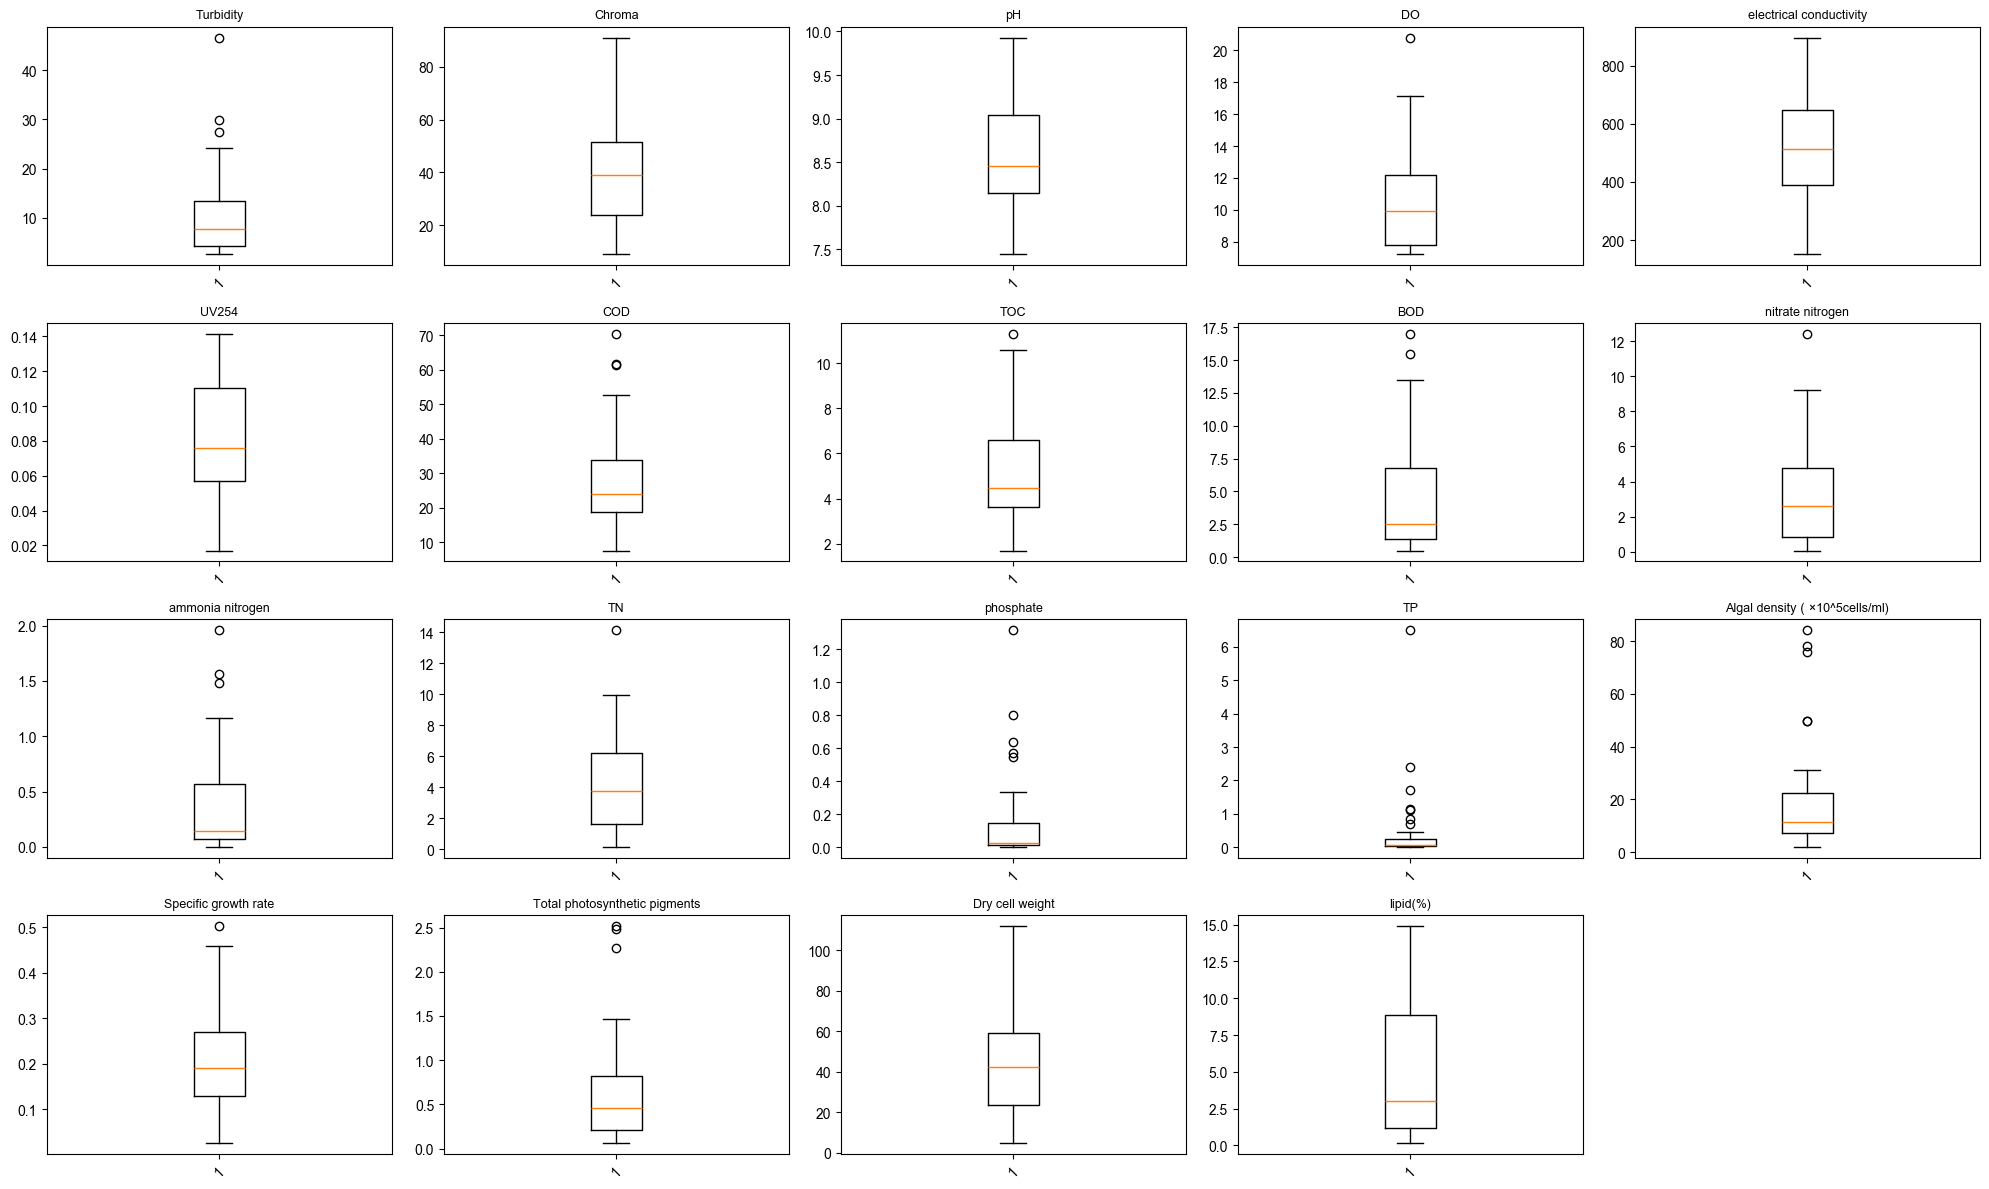

In [7]:
# KNN 填充后：箱线图查看离群值概况（标准化前）
num_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()

# IQR 规则统计离群点数量
outlier_summary = []
for col in num_cols:
    s = df_filled[col].dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask = (s < lower) | (s > upper)
    outlier_summary.append({
        'column': col,
        'n': s.shape[0],
        'outliers': int(mask.sum()),
        'lower': lower,
        'upper': upper,
        'min': s.min(),
        'max': s.max(),
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('outliers', ascending=False)
print('IQR 规则离群点数量（标准化前）：')
print(outlier_df.reset_index(drop=True))

# 箱线图展示
n_cols = 5
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()
for idx, col in enumerate(num_cols):
    axes[idx].boxplot(df_filled[col].dropna(), vert=True)
    axes[idx].set_title(col, fontsize=9)
    axes[idx].tick_params(axis='x', labelrotation=45)

# 关闭多余子图
for ax in axes[len(num_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# 对离群明显的特征先做温和缩尾 (winsorize)，再用 Yeo-Johnson 标准化
from sklearn.preprocessing import PowerTransformer
from collections import OrderedDict

# 使用公共常量 TARGET_COL
y = df_filled[TARGET_COL].copy()

feature_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(TARGET_COL)
X = df_filled[feature_cols].copy()

# 处理可能存在的 inf 值
X = X.replace([np.inf, -np.inf], np.nan)

# 如果还有 NaN，用列中位数补全
for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

# 基于 IQR 检测离群，离群列做 1%/99% 分位缩尾
winsor_bounds = OrderedDict()
for col in feature_cols:
    s = X[col]
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    if ((s < lower) | (s > upper)).any():
        lo, hi = s.quantile([0.01, 0.99])
        winsor_bounds[col] = (lo, hi)
        X[col] = s.clip(lower=lo, upper=hi)

print(f'缩尾处理列数: {len(winsor_bounds)}')
if winsor_bounds:
    for k, (lo, hi) in winsor_bounds.items():
        print(f'  {k}: 1%={lo:.4f}, 99%={hi:.4f}')

# Yeo-Johnson 变换 + 标准化
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled = pt.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df_filled.index)

# 安全检查
if X_scaled_df.isna().any().any():
    X_scaled_df = X_scaled_df.fillna(0)
    print('注意: 变换后发现 NaN，已填充为 0')

print(f'Yeo-Johnson 标准化完成，共 {len(feature_cols)} 个特征')
for col in feature_cols[:3]:
    m = X_scaled_df[col].mean()
    s = X_scaled_df[col].std(ddof=0)
    print(f'  {col}: 均值={m:.4f}, 标准差={s:.4f}')


缩尾处理列数: 13
  Turbidity: 1%=2.6560, 99%=40.7525
  DO: 1%=7.2205, 99%=19.5185
  COD: 1%=8.3755, 99%=67.3550
  TOC: 1%=1.7390, 99%=11.0650
  BOD: 1%=0.5000, 99%=16.4750
  nitrate nitrogen: 1%=0.0752, 99%=11.2974
  ammonia nitrogen: 1%=0.0000, 99%=1.8200
  TN: 1%=0.3625, 99%=12.6901
  phosphate: 1%=0.0031, 99%=1.1359
  TP: 1%=0.0100, 99%=5.0645
  Algal density（×10^5cells/ml): 1%=2.9288, 99%=82.0967
  Specific growth rate: 1%=0.0416, 99%=0.4869
  Total photosynthetic pigments: 1%=0.0706, 99%=2.5024
Yeo-Johnson 标准化完成，共 18 个特征
  Turbidity: 均值=-0.0000, 标准差=1.0000
  Chroma: 均值=0.0000, 标准差=1.0000
  pH: 均值=-0.0000, 标准差=1.0000


In [9]:
# 标准化结果打包与保存
df_standardized = X_scaled_df.copy()
df_standardized[TARGET_COL] = y

output_path = '../data/processed/data_standardized.xlsx'
df_standardized.to_excel(output_path, index=False)
print(f'标准化数据保存路径: {output_path}')
print(f'数据状态: {df_standardized.shape}')


标准化数据保存路径: ../data/processed/data_standardized.xlsx
数据状态: (36, 19)


## 特征筛选

In [10]:
# 优化：使用公共常量 TARGET_COL，避免重复定义
df = df_standardized.copy()
y = df[TARGET_COL].values

feature_cols = df.columns.tolist()
feature_cols.remove(TARGET_COL)

X = df[feature_cols].values

print(f'特征数量: {len(feature_cols)}')
print(f'样本数量: {len(y)}')

特征数量: 18
样本数量: 36


In [11]:
# Pearson 相关系数
# 简单直观，看特征和目标的线性相关程度

corr_scores = {}
for i, col in enumerate(feature_cols):
    if np.isclose(np.std(X[:, i]), 0):
        corr_scores[col] = 0.0
        continue
    corr = np.corrcoef(X[:, i], y)[0, 1]
    corr_scores[col] = 0.0 if np.isnan(corr) else abs(corr)

print('相关系数前 14 ：')
for feat, score in sorted(corr_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

相关系数前 14 ：
  pH: 0.162
  TOC: 0.147
  DO: 0.137
  Turbidity: 0.127
  Total photosynthetic pigments: 0.126
  nitrate nitrogen: 0.107
  Dry cell weight: 0.102
  ammonia nitrogen: 0.090
  Algal density（×10^5cells/ml): 0.084
  BOD: 0.079
  COD: 0.052
  Specific growth rate: 0.051
  electrical conductivity: 0.049
  Chroma: 0.028


In [12]:
# 随机森林
# 捕捉非线性关系，根据特征在树分裂时的贡献打分
rf = RandomForestRegressor(n_estimators=1000, max_depth=3,min_samples_leaf=3,min_samples_split=6,max_features="sqrt", random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_scores = dict(zip(feature_cols, rf.feature_importances_))

print('随机森林前 14 ：')
for feat, score in sorted(rf_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.4f}')

随机森林前 14 ：
  nitrate nitrogen: 0.1317
  DO: 0.1106
  TN: 0.0900
  Total photosynthetic pigments: 0.0791
  BOD: 0.0755
  Turbidity: 0.0700
  TP: 0.0678
  phosphate: 0.0471
  pH: 0.0455
  TOC: 0.0437
  Algal density（×10^5cells/ml): 0.0428
  Dry cell weight: 0.0335
  COD: 0.0318
  Chroma: 0.0303


In [13]:
# PLS 回归 (VIP 得分)
# VIP > 1 认为是重要特征

n_samples, n_features = X.shape
n_components = min(3, n_samples - 1, n_features)

pls = PLSRegression(n_components=n_components,scale=False)
pls.fit(X, y)

def calculate_vip(pls):
    t = pls.x_scores_          # (n, h)
    w = pls.x_weights_         # (p, h)
    q = pls.y_loadings_        # (m, h)  m=targets

    p, h = w.shape

    # 每个成分解释的 y 方差贡献（常见写法）
    s = np.sum(t**2, axis=0) * np.sum(q**2, axis=0)   # (h,)
    total_s = np.sum(s)
    if np.isclose(total_s, 0):
        return np.zeros(p)

    # 归一化每个成分的权重向量
    w_norm2 = (w / np.linalg.norm(w, axis=0))**2       # (p, h)

    vip = np.sqrt(p * (w_norm2 @ s) / total_s)         # (p,)
    return vip


pls_scores = dict(zip(feature_cols, calculate_vip(pls)))

print('PLS VIP 前 14 名：')
for feat, score in sorted(pls_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

PLS VIP 前 14 名：
  Total photosynthetic pigments: 1.613
  TN: 1.368
  DO: 1.239
  pH: 1.200
  BOD: 1.196
  TOC: 1.118
  nitrate nitrogen: 1.107
  Turbidity: 1.069
  Dry cell weight: 1.015
  electrical conductivity: 0.877
  Algal density（×10^5cells/ml): 0.851
  ammonia nitrogen: 0.850
  TP: 0.734
  phosphate: 0.709


In [14]:
# 递归特征消除 (RFE)
# 反复训练模型，每次剔除最不重要的特征，最后看哪些留到了最后

base_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0])
rfe = RFE(estimator=base_model, n_features_to_select=6, step=1)
rfe.fit(X, y)

max_rank = max(rfe.ranking_)
rfe_scores = {col: max_rank - rfe.ranking_[i] + 1 for i, col in enumerate(feature_cols)}

print('【RFE】最终保留的 6 个特征：')
for feat in np.array(feature_cols)[rfe.support_]:
    print(f'  {feat}')

【RFE】最终保留的 6 个特征：
  Turbidity
  pH
  TOC
  nitrate nitrogen
  Total photosynthetic pigments
  Dry cell weight


In [15]:
# Spearman 秩相关系数
# 衡量单调关系（不仅限于线性），对异常值更稳健

spearman_scores = {}
for i, col in enumerate(feature_cols):
    xi = X[:, i]
    if np.isclose(np.std(xi), 0):
        spearman_scores[col] = 0.0
        continue
    rho, _ = stats.spearmanr(xi, y, nan_policy='omit')
    spearman_scores[col] = 0.0 if np.isnan(rho) else abs(rho)


print('Spearman 秩相关前 14：')
for feat, score in sorted(spearman_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

Spearman 秩相关前 14：
  Turbidity: 0.246
  pH: 0.202
  TOC: 0.151
  DO: 0.143
  Dry cell weight: 0.141
  Total photosynthetic pigments: 0.140
  Chroma: 0.123
  electrical conductivity: 0.084
  Algal density（×10^5cells/ml): 0.063
  ammonia nitrogen: 0.059
  TN: 0.058
  BOD: 0.053
  phosphate: 0.051
  TP: 0.045


In [16]:
# 互信息 (Mutual Information)
# 捕捉任意类型的依赖关系（线性/非线性），基于信息论
const_mask = np.isclose(np.std(X, axis=0), 0)
mi_arr = mutual_info_regression(X, y, random_state=42, n_neighbors=5)
mi_arr[const_mask] = 0.0

mi_scores = dict(zip(feature_cols, mi_arr))

print('互信息 MI 前 14：')
for feat, score in sorted(mi_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.4f}')

互信息 MI 前 14：
  nitrate nitrogen: 0.2856
  TN: 0.1857
  TOC: 0.1025
  Algal density（×10^5cells/ml): 0.0685
  Total photosynthetic pigments: 0.0362
  Turbidity: 0.0284
  Chroma: 0.0155
  Specific growth rate: 0.0030
  pH: 0.0000
  DO: 0.0000
  electrical conductivity: 0.0000
  UV254: 0.0000
  COD: 0.0000
  BOD: 0.0000


In [17]:
# 综合得分只看 Spearman 与 PLS (两种方法平均)

def normalize(scores):
    vals = np.array(list(scores.values()))
    vals = np.nan_to_num(vals, nan=0.0)
    if vals.max() - vals.min() > 0:
        normed = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        normed = np.zeros_like(vals)
    return dict(zip(scores.keys(), normed))

scores_dict = {
    'Spearman': spearman_scores,
    'PLS': pls_scores
}

feature_cols = list(scores_dict['Spearman'].keys())

data = {'feature': feature_cols}
for name, scores in scores_dict.items():
    data[f'{name}_Raw'] = [scores[f] for f in feature_cols]
for name, scores in scores_dict.items():
    norm_scores = normalize(scores)
    data[name] = [norm_scores[f] for f in feature_cols]

summary_df = pd.DataFrame(data)
summary_df['Average'] = summary_df[list(scores_dict.keys())].mean(axis=1)
summary_df = summary_df.sort_values('Average', ascending=False)

print('【综合排名】前 10 名（Spearman + PLS）：')
print(summary_df[['feature', 'Average']].head(10).to_string(index=False))


【综合排名】前 10 名（Spearman + PLS）：
                      feature  Average
                    Turbidity 0.785145
Total photosynthetic pigments 0.779338
                           pH 0.745259
                           DO 0.638423
                          TOC 0.606438
              Dry cell weight 0.544798
                           TN 0.511913
                          BOD 0.433134
      electrical conductivity 0.372881
                       Chroma 0.357930


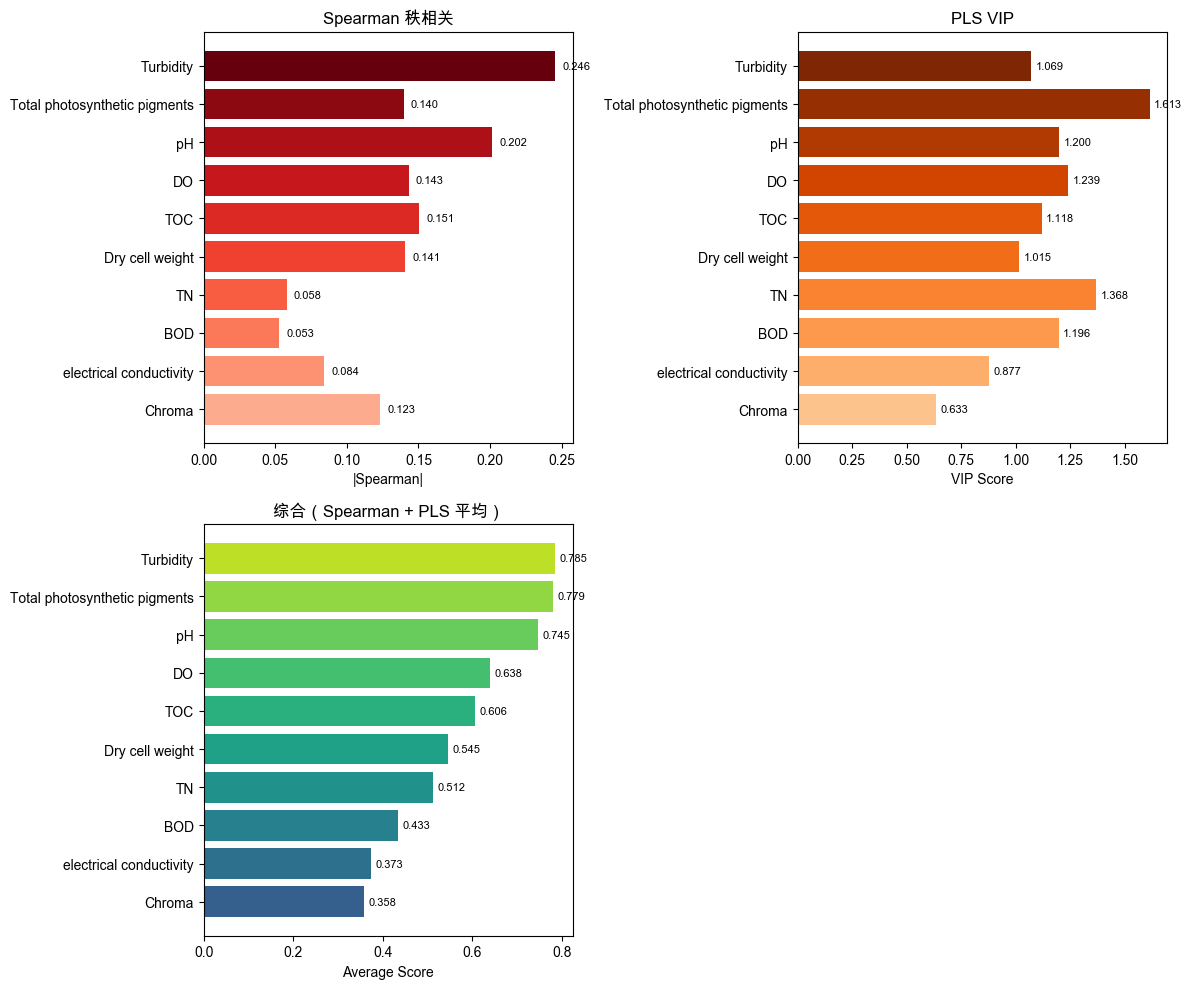

图表保存至: ../results/feature_selection_comparison_raw.png


In [18]:
top_n = 10
top_features = summary_df.head(top_n)['feature'].tolist()
plot_df = summary_df[summary_df['feature'].isin(top_features)].copy().set_index('feature')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Spearman
ax = axes[0]
vals = plot_df.loc[top_features, 'Spearman_Raw'].values
ax.barh(top_features, vals, color=plt.cm.Reds(np.linspace(0.3, 1, top_n))[::-1])
ax.set_xlabel('|Spearman|')
ax.set_title('Spearman 秩相关')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=8)

# PLS
ax = axes[1]
vals = plot_df.loc[top_features, 'PLS_Raw'].values
ax.barh(top_features, vals, color=plt.cm.Oranges(np.linspace(0.3, 1, top_n))[::-1])
ax.set_xlabel('VIP Score')
ax.set_title('PLS VIP')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=8)

# Average (Spearman + PLS)
ax = axes[2]
vals = plot_df.loc[top_features, 'Average'].values
ax.barh(top_features, vals, color=plt.cm.viridis(np.linspace(0.3, 0.9, top_n))[::-1])
ax.set_xlabel('Average Score')
ax.set_title('综合（Spearman + PLS 平均）')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# hide unused subplot
axes[3].axis('off')

plt.tight_layout()
plt.savefig('../results/feature_selection_comparison_raw.png', dpi=300, bbox_inches='tight')
plt.show()

print('图表保存至: ../results/feature_selection_comparison_raw.png')


In [19]:
# 保存结果
summary_df.to_excel('../results/feature_selection_results_raw.xlsx', index=False)

print('结果已保存')
print('前 10 特征：')
for i, feat in enumerate(summary_df.head(10)['feature'].tolist(), 1):
    print(f'  {i}. {feat}')

结果已保存
前 10 特征：
  1. Turbidity
  2. Total photosynthetic pigments
  3. pH
  4. DO
  5. TOC
  6. Dry cell weight
  7. TN
  8. BOD
  9. electrical conductivity
  10. Chroma


  transform      RMSE       MAE        R2
0       原始y  5.280918  4.239948 -0.196732
1  log1p(y)  5.036957  3.751640 -0.088716


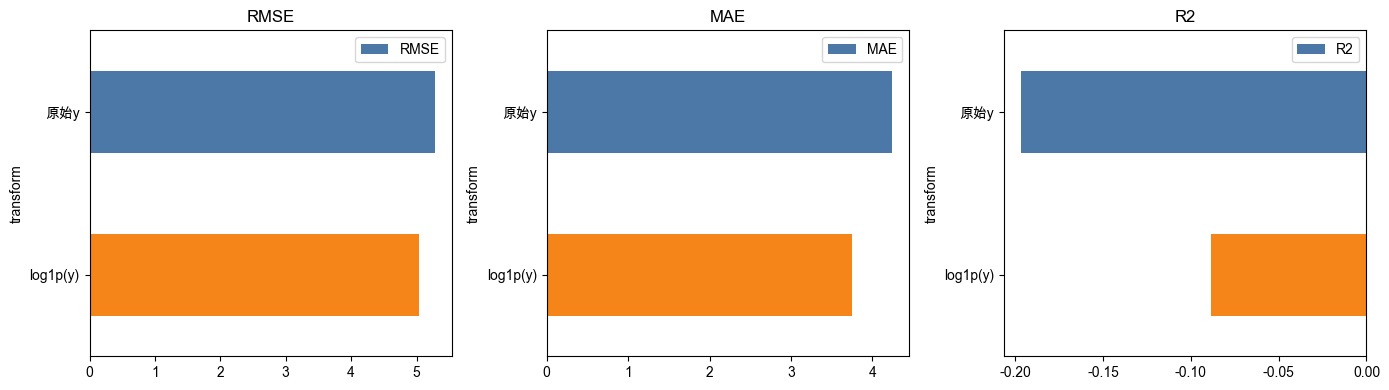

图已保存: ../results/xgb_full_repeated_raw.png


In [20]:
# 基线 A：全特征 XGBoost Repeated 5×5 CV（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

X = df_standardized.drop(columns=[TARGET_COL])
y = df_standardized[TARGET_COL]

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
model_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
    reg_lambda=1.0, random_state=42, objective='reg:squarederror'
)

results = []
for transform in [False, True]:
    preds, truths = [], []
    for train_idx, test_idx in rkf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        y_train_fit = np.log1p(y_train) if transform else y_train
        model = XGBRegressor(**model_params)
        model.fit(X_train, y_train_fit)
        y_pred = model.predict(X_test)
        if transform:
            y_pred = np.expm1(y_pred)
        preds.append(np.array(y_pred).ravel())
        truths.append(y_test.values)
    y_pred_all = np.concatenate(preds)
    y_true_all = np.concatenate(truths)
    rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    tag = 'log1p(y)' if transform else '原始y'
    results.append({'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, metric, colors in zip(axes, ['RMSE','MAE','R2'], [['#4C78A8','#F58518']]*3):
    res_df.plot(kind='barh', x='transform', y=metric, ax=ax, color=colors)
    ax.set_title(metric)
    ax.invert_yaxis()
plt.tight_layout()
img_path = '../results/xgb_full_repeated_raw.png'
plt.savefig(img_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'图已保存: {img_path}')


  transform      RMSE       MAE        R2
0       原始y  4.902174  3.975651 -0.031230
1  log1p(y)  4.850889  3.536797 -0.009766


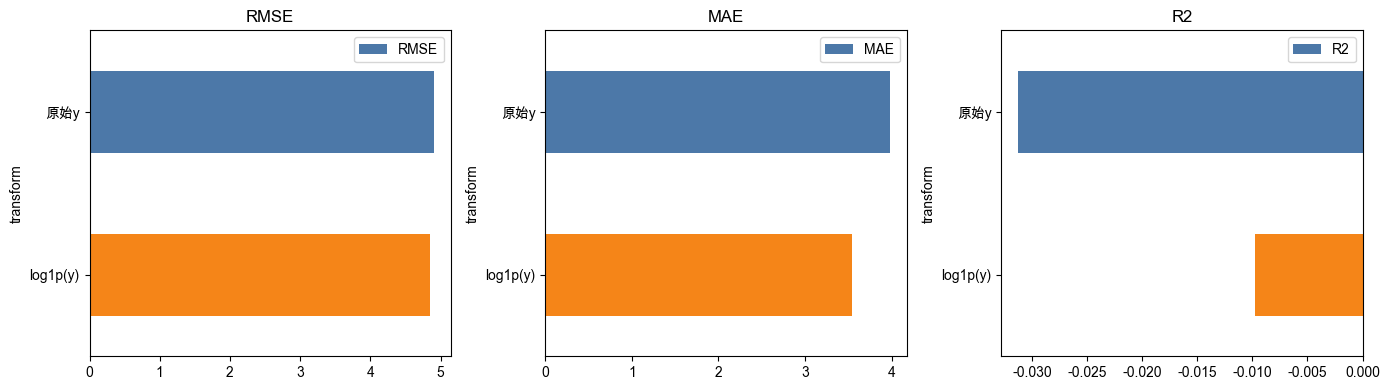

图已保存: ../results/xgb_subset_repeated_raw.png
特征列表: ['Turbidity', 'Total photosynthetic pigments', 'pH', 'DO', 'TOC', 'Dry cell weight']


In [21]:
# 基线 B：前6特征 XGBoost Repeated 5×5 CV（图表， RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

subset_features = summary_df.head(6)['feature'].tolist()
X = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
model_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
    reg_lambda=1.0, random_state=42, objective='reg:squarederror'
)

results = []
for transform in [False, True]:
    preds, truths = [], []
    for train_idx, test_idx in rkf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        y_train_fit = np.log1p(y_train) if transform else y_train
        model = XGBRegressor(**model_params)
        model.fit(X_train, y_train_fit)
        y_pred = model.predict(X_test)
        if transform:
            y_pred = np.expm1(y_pred)
        preds.append(np.array(y_pred).ravel())
        truths.append(y_test.values)
    y_pred_all = np.concatenate(preds)
    y_true_all = np.concatenate(truths)
    rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    tag = 'log1p(y)' if transform else '原始y'
    results.append({'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, metric, colors in zip(axes, ['RMSE','MAE','R2'], [['#4C78A8','#F58518']]*3):
    res_df.plot(kind='barh', x='transform', y=metric, ax=ax, color=colors)
    ax.set_title(metric)
    ax.invert_yaxis()
plt.tight_layout()
img_path = '../results/xgb_subset_repeated_raw.png'
plt.savefig(img_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'图已保存: {img_path}')
print(f'特征列表: {subset_features}')


    set transform      RMSE       MAE        R2
0   全特征       原始y  5.052806  4.047160 -0.095578
1   全特征  log1p(y)  4.912548  3.585016 -0.035599
2  前6特征       原始y  4.812833  3.905215  0.006015
3  前6特征  log1p(y)  4.605513  3.374752  0.089806


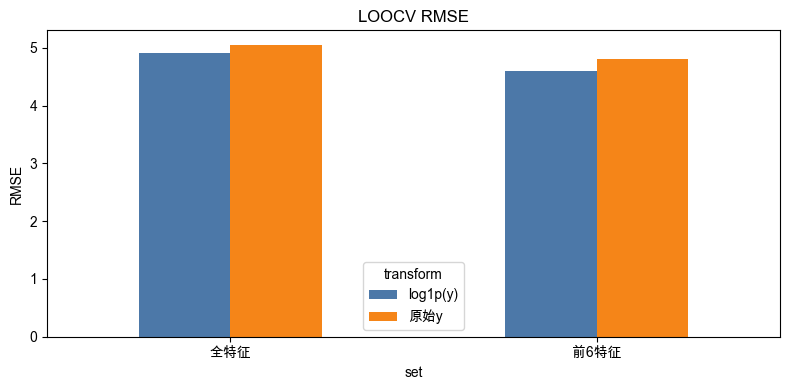

RMSE 图已保存: ../results/xgb_loocv_raw_rmse.png


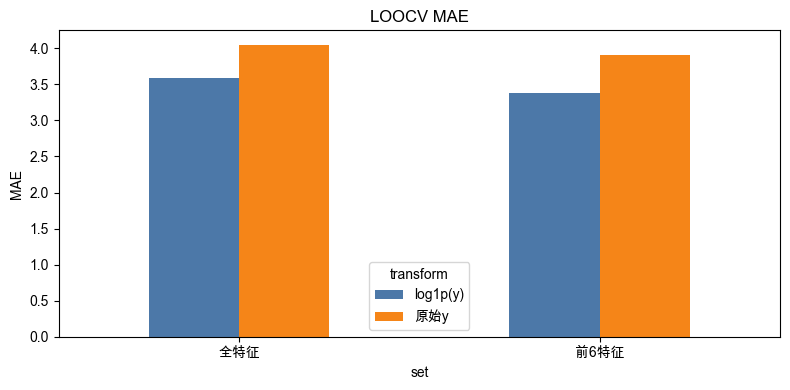

MAE 图已保存: ../results/xgb_loocv_raw_mae.png


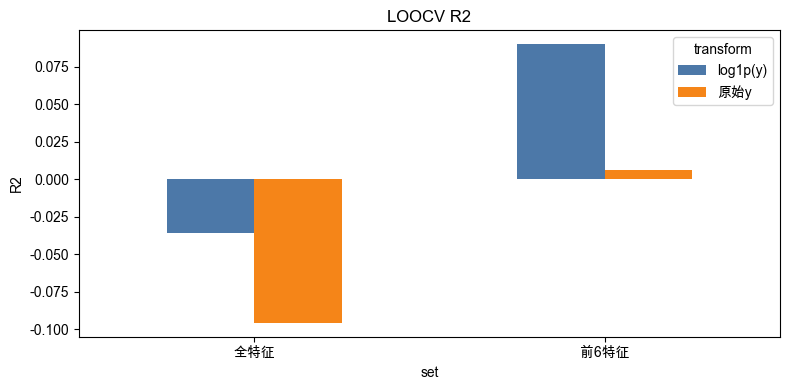

R2 图已保存: ../results/xgb_loocv_raw_r2.png
特征列表: ['Turbidity', 'Total photosynthetic pigments', 'pH', 'DO', 'TOC', 'Dry cell weight']


In [22]:
# LOOCV：全特征 vs 前6，XGBoost（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

X_full = df_standardized.drop(columns=[TARGET_COL])
subset_features = summary_df.head(6)['feature'].tolist()
X_sub = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

model_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
    reg_lambda=1.0, random_state=42, objective='reg:squarederror'
)

loo = LeaveOneOut()
results = []
for name, X_curr in [('全特征', X_full), ('前6特征', X_sub)]:
    for transform in [False, True]:
        preds, truths = [], []
        for train_idx, test_idx in loo.split(X_curr):
            X_train, X_test = X_curr.iloc[train_idx], X_curr.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            y_train_fit = np.log1p(y_train) if transform else y_train
            model = XGBRegressor(**model_params)
            model.fit(X_train, y_train_fit)
            y_pred = model.predict(X_test)
            if transform:
                y_pred = np.expm1(y_pred)
            preds.append(np.array(y_pred).ravel())
            truths.append(y_test.values)
        y_pred_all = np.concatenate(preds)
        y_true_all = np.concatenate(truths)
        rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
        mae = mean_absolute_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)
        tag = 'log1p(y)' if transform else '原始y'
        results.append({'set': name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(8,4))
    pivot = res_df.pivot(index='set', columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'LOOCV {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=0)
    plt.tight_layout()
    img_path = f"../results/xgb_loocv_raw_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')
print(f'特征列表: {subset_features}')


          model transform      RMSE       MAE        R2
0         Ridge       原始y  6.461576  4.906230 -0.791657
1         Ridge  log1p(y)  5.896807  4.329897 -0.492148
2         Lasso       原始y  6.675709  4.967235 -0.912374
3         Lasso  log1p(y)  6.120590  4.380761 -0.607551
4    ElasticNet       原始y  6.567478  4.867438 -0.850867
5    ElasticNet  log1p(y)  5.965992  4.253503 -0.527367
6           PLS       原始y  7.294591  5.846883 -1.283389
7           PLS  log1p(y)  6.924901  5.229711 -1.057810
8  RandomForest       原始y  5.131900  4.225537 -0.130146
9  RandomForest  log1p(y)  5.228554  3.872401 -0.173117


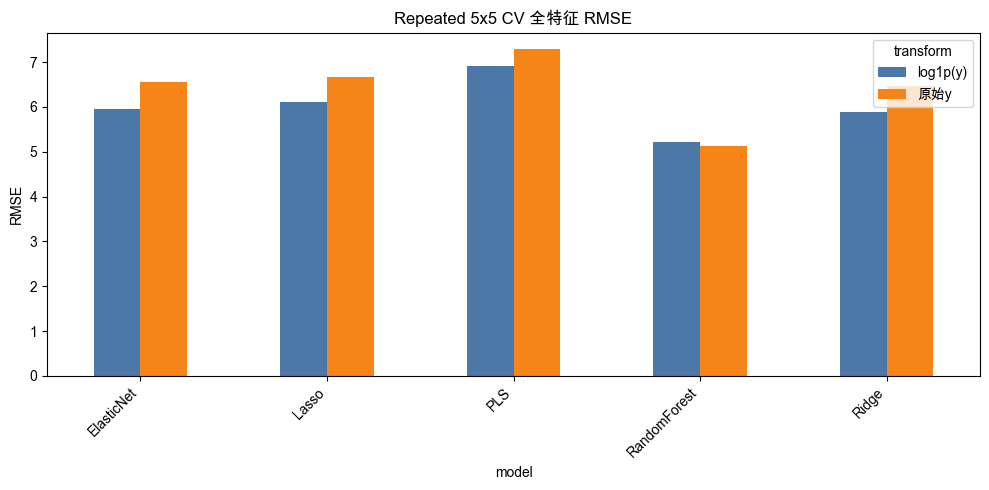

RMSE 图已保存: ../results/lin_pls_rf_full_raw_rmse.png


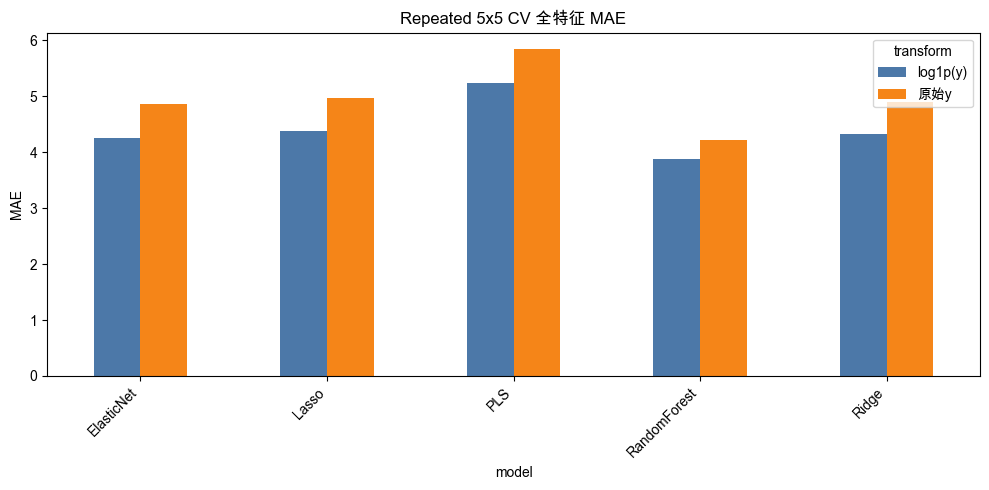

MAE 图已保存: ../results/lin_pls_rf_full_raw_mae.png


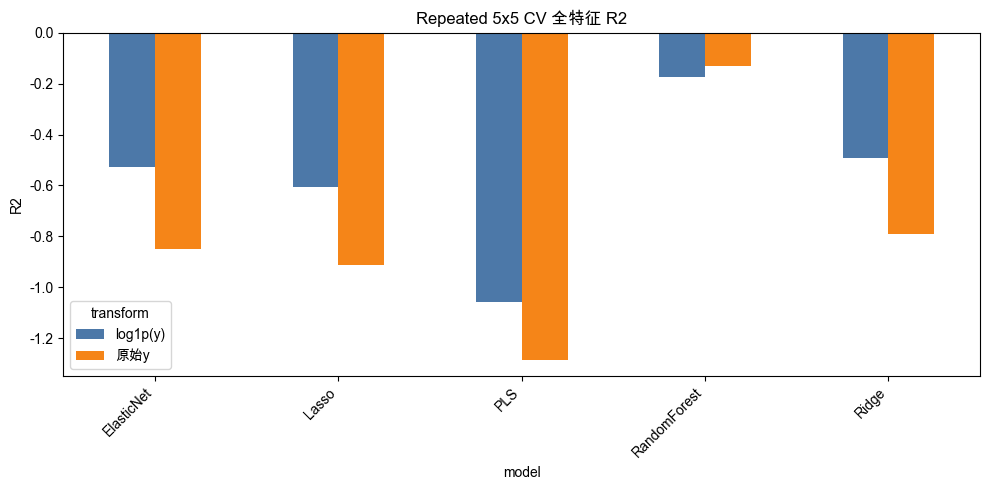

R2 图已保存: ../results/lin_pls_rf_full_raw_r2.png


In [23]:
# 基线 C：线性/PLS/RF 全特征 Repeated 5×5 CV（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

X = df_standardized.drop(columns=[TARGET_COL])
y = df_standardized[TARGET_COL]

models = {
    'Ridge': lambda n_features: Ridge(alpha=1.0, random_state=42),
    'Lasso': lambda n_features: Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet': lambda n_features: ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'PLS': lambda n_features: PLSRegression(n_components=min(3, n_features, len(y) - 1), scale=False),
    'RandomForest': lambda n_features: RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
}

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
results = []
for model_name, make_model in models.items():
    n_features = X.shape[1]
    for transform in [False, True]:
        preds, truths = [], []
        for train_idx, test_idx in rkf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            y_train_fit = np.log1p(y_train) if transform else y_train
            model = make_model(n_features)
            model.fit(X_train, y_train_fit)
            y_pred = model.predict(X_test)
            if transform:
                y_pred = np.expm1(y_pred)
            preds.append(np.array(y_pred).ravel())
            truths.append(y_test.values)
        y_pred_all = np.concatenate(preds)
        y_true_all = np.concatenate(truths)
        rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
        mae = mean_absolute_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)
        tag = 'log1p(y)' if transform else '原始y'
        results.append({'model': model_name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(10,5))
    pivot = res_df.pivot(index='model', columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'Repeated 5x5 CV 全特征 {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    img_path = f"../results/lin_pls_rf_full_raw_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')


          model transform      RMSE       MAE        R2
0         Ridge       原始y  5.244860  4.357590 -0.180445
1         Ridge  log1p(y)  5.151754  3.919836 -0.138907
2         Lasso       原始y  5.297902  4.353885 -0.204442
3         Lasso  log1p(y)  5.176550  3.955824 -0.149897
4    ElasticNet       原始y  5.288438  4.352094 -0.200143
5    ElasticNet  log1p(y)  5.198319  3.967814 -0.159588
6           PLS       原始y  5.558060  4.552216 -0.325637
7           PLS  log1p(y)  5.435739  4.113018 -0.267930
8  RandomForest       原始y  4.880683  3.964035 -0.022208
9  RandomForest  log1p(y)  5.019945  3.688768 -0.081374


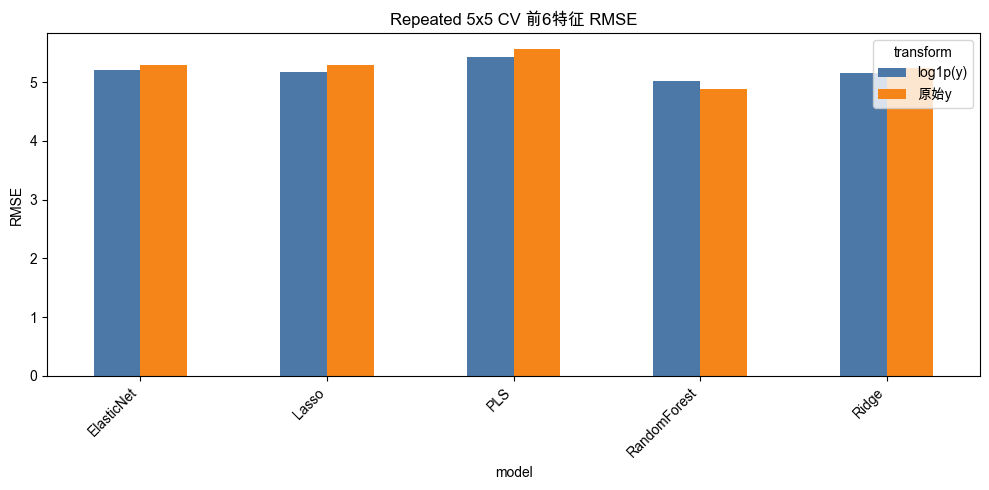

RMSE 图已保存: ../results/lin_pls_rf_sub_raw_rmse.png


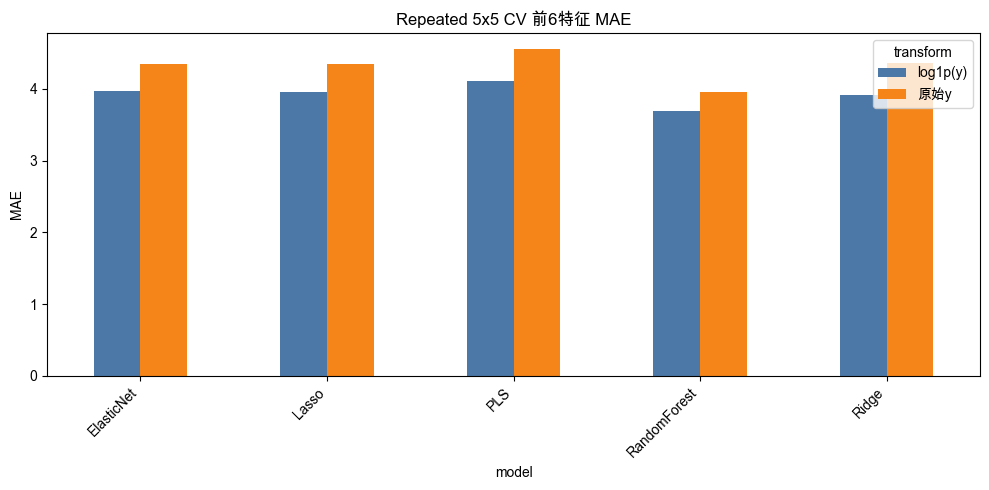

MAE 图已保存: ../results/lin_pls_rf_sub_raw_mae.png


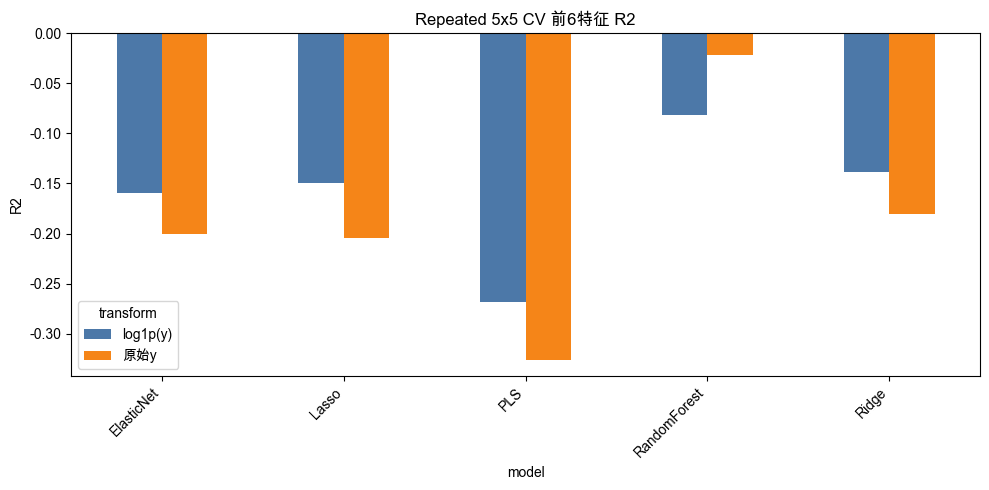

R2 图已保存: ../results/lin_pls_rf_sub_raw_r2.png
特征列表: ['Turbidity', 'Total photosynthetic pigments', 'pH', 'DO', 'TOC', 'Dry cell weight']


In [24]:
# 基线 D：线性/PLS/RF 前6特征 Repeated 5×5 CV（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

subset_features = summary_df.head(6)['feature'].tolist()
X = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

models = {
    'Ridge': lambda n_features: Ridge(alpha=1.0, random_state=42),
    'Lasso': lambda n_features: Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet': lambda n_features: ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'PLS': lambda n_features: PLSRegression(n_components=min(3, n_features, len(y) - 1), scale=False),
    'RandomForest': lambda n_features: RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
}

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
results = []
for model_name, make_model in models.items():
    n_features = X.shape[1]
    for transform in [False, True]:
        preds, truths = [], []
        for train_idx, test_idx in rkf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            y_train_fit = np.log1p(y_train) if transform else y_train
            model = make_model(n_features)
            model.fit(X_train, y_train_fit)
            y_pred = model.predict(X_test)
            if transform:
                y_pred = np.expm1(y_pred)
            preds.append(np.array(y_pred).ravel())
            truths.append(y_test.values)
        y_pred_all = np.concatenate(preds)
        y_true_all = np.concatenate(truths)
        rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
        mae = mean_absolute_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)
        tag = 'log1p(y)' if transform else '原始y'
        results.append({'model': model_name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(10,5))
    pivot = res_df.pivot(index='model', columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'Repeated 5x5 CV 前6特征 {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    img_path = f"../results/lin_pls_rf_sub_raw_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')
print(f'特征列表: {subset_features}')


     set         model transform      RMSE       MAE        R2
0    全特征         Ridge       原始y  6.044772  4.540927 -0.567971
1    全特征         Ridge  log1p(y)  5.352969  4.046478 -0.229610
2    全特征         Lasso       原始y  6.230289  4.289401 -0.665691
3    全特征         Lasso  log1p(y)  5.560240  4.170771 -0.326677
4    全特征    ElasticNet       原始y  6.103968  4.308171 -0.598831
5    全特征    ElasticNet  log1p(y)  5.371725  3.990734 -0.238242
6    全特征           PLS       原始y  7.058911  5.900464 -1.138225
7    全特征           PLS  log1p(y)  6.629517  5.115625 -0.886000
8    全特征  RandomForest       原始y  5.192504  4.330560 -0.156995
9    全特征  RandomForest  log1p(y)  5.189695  3.815586 -0.155744
10  前6特征         Ridge       原始y  5.135580  4.252280 -0.131767
11  前6特征         Ridge  log1p(y)  5.064395  3.822253 -0.100609
12  前6特征         Lasso       原始y  5.160343  4.239341 -0.142708
13  前6特征         Lasso  log1p(y)  5.044523  3.821541 -0.091989
14  前6特征    ElasticNet       原始y  5.155403  4.241211 -0

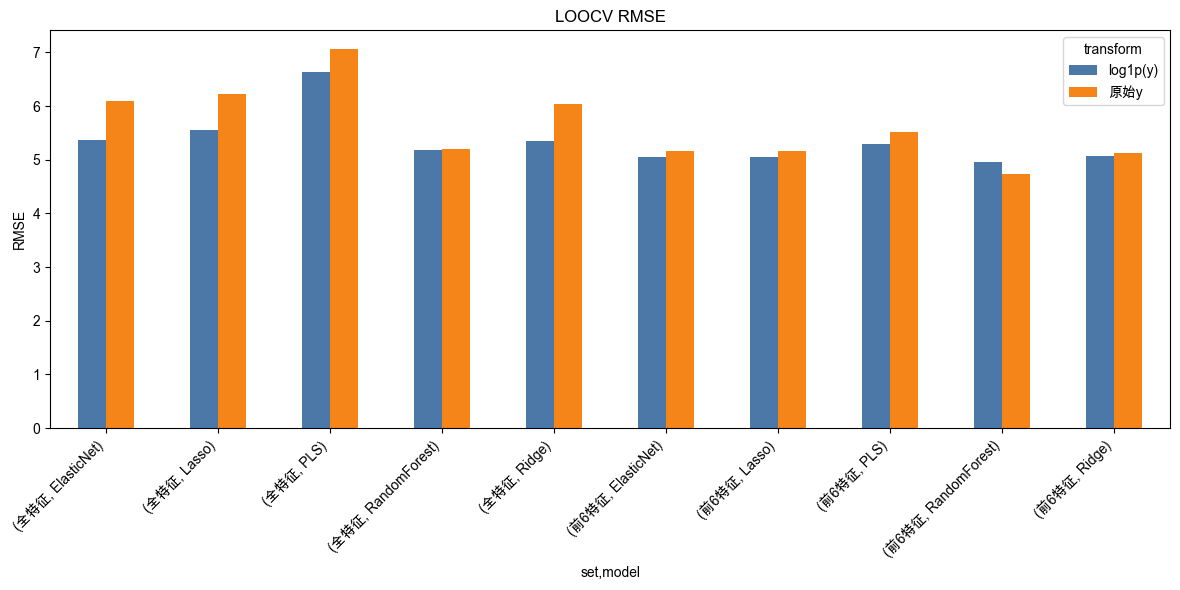

RMSE 图已保存: ../results/lin_pls_rf_loo_raw_rmse.png


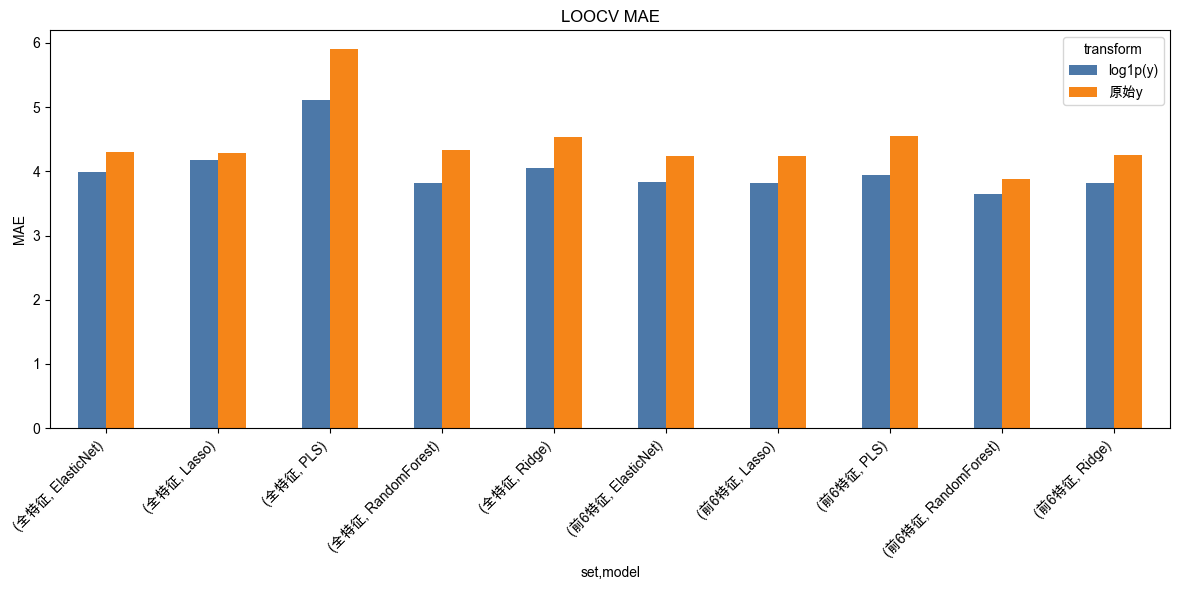

MAE 图已保存: ../results/lin_pls_rf_loo_raw_mae.png


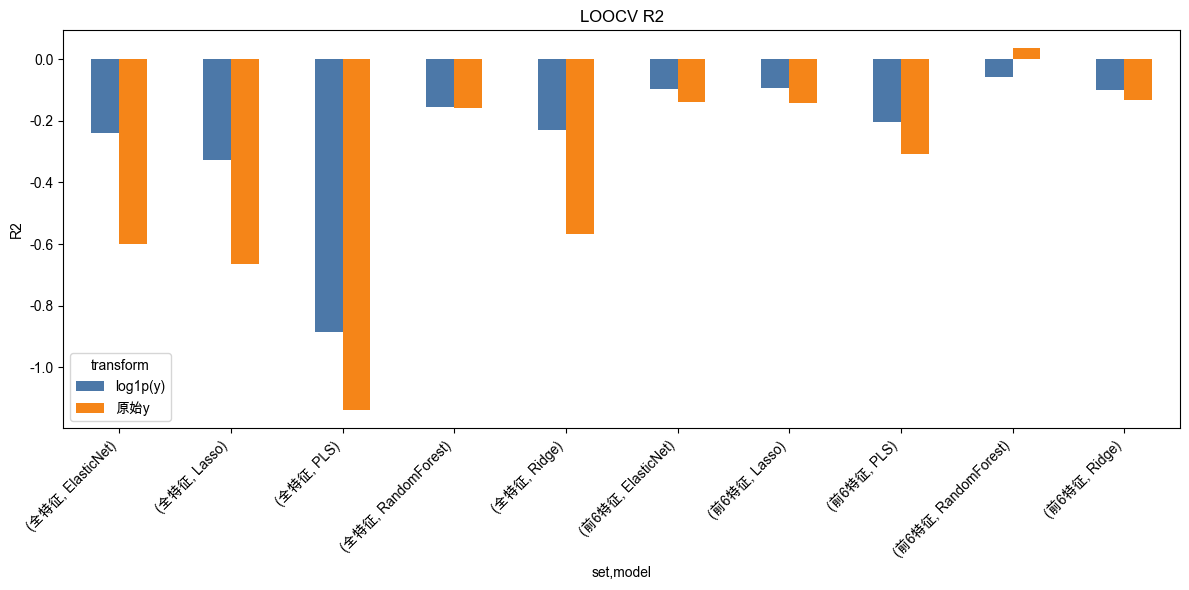

R2 图已保存: ../results/lin_pls_rf_loo_raw_r2.png
特征列表: ['Turbidity', 'Total photosynthetic pigments', 'pH', 'DO', 'TOC', 'Dry cell weight']


In [25]:
# 线性/PLS/RF LOOCV 对照（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

X_full = df_standardized.drop(columns=[TARGET_COL])
subset_features = summary_df.head(6)['feature'].tolist()
X_sub = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

models = {
    'Ridge': lambda n_features: Ridge(alpha=1.0, random_state=42),
    'Lasso': lambda n_features: Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet': lambda n_features: ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'PLS': lambda n_features: PLSRegression(n_components=min(3, n_features, len(y) - 1), scale=False),
    'RandomForest': lambda n_features: RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
}

loo = LeaveOneOut()
results = []
for name, X_curr in [('全特征', X_full), ('前6特征', X_sub)]:
    for model_name, make_model in models.items():
        for transform in [False, True]:
            preds, truths = [], []
            for train_idx, test_idx in loo.split(X_curr):
                X_train, X_test = X_curr.iloc[train_idx], X_curr.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                y_train_fit = np.log1p(y_train) if transform else y_train
                model = make_model(X_curr.shape[1])
                model.fit(X_train, y_train_fit)
                y_pred = model.predict(X_test)
                if transform:
                    y_pred = np.expm1(y_pred)
                preds.append(np.array(y_pred).ravel())
                truths.append(y_test.values)
            y_pred_all = np.concatenate(preds)
            y_true_all = np.concatenate(truths)
            rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
            mae = mean_absolute_error(y_true_all, y_pred_all)
            r2 = r2_score(y_true_all, y_pred_all)
            tag = 'log1p(y)' if transform else '原始y'
            results.append({'set': name, 'model': model_name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(12,6))
    pivot = res_df.pivot(index=['set','model'], columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'LOOCV {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    img_path = f"../results/lin_pls_rf_loo_raw_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')
print(f'特征列表: {subset_features}')
